In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import mixture
from scipy.integrate import quad, dblquad
from IPython.display import Image
plt.rcParams['figure.figsize'] = (12.0, 8.0) 

## Weak Gravitational Lensing
Bending of light by nearby mass is gravitational lensing. In the weak lensing regime this deflection is impossible to detect in a single background source. However, the presence of the foreground mass can be detected, as a  systematic alignment of background sources around the lensing mass. Weak gravitational lensing is thus an intrinsically statistical measurement.
<img src="exp_1.png">
## Measuring Shape
The reduced shear describes the shape distortion is described by a 2-component quantity, most conveniently written as a complex number $g$. 
However, galaxies are not intrinsically round, so that the observed ellipticity is a combination of intrinsic ellipticity and shear.
### Reduced Shear:  $g=g_1+ig_2=|g|e^{i2\phi}$  ;       Intrinsic ellipticity: $e=e_1+ie_2=|e|e^{i2\beta}$ 


### Observed shape: $e^{obs}=\frac{e+g}{1+g^*e}$

Estimating the (reduced) shear:  We make the assumption that the intrinsic orientation of galaxies ($e$) is random $<e>$=0
If |g|<1 :  $<e_{obs}>=g $

## Aim of project : Measure the instrinsic ellipticity distribution of galaxies from observed shape distribution
The intrinsic shape distribution in modelled as a Gaussian Mixture Model(GMM)

### $Pr(e)=\Sigma_i^{N_g} w_i \mathcal{N}(\mu_i,\sigma_i)$

Observed shapes  catalog of 10000 galaxies measured in the Great3 challenge is taken as the input data


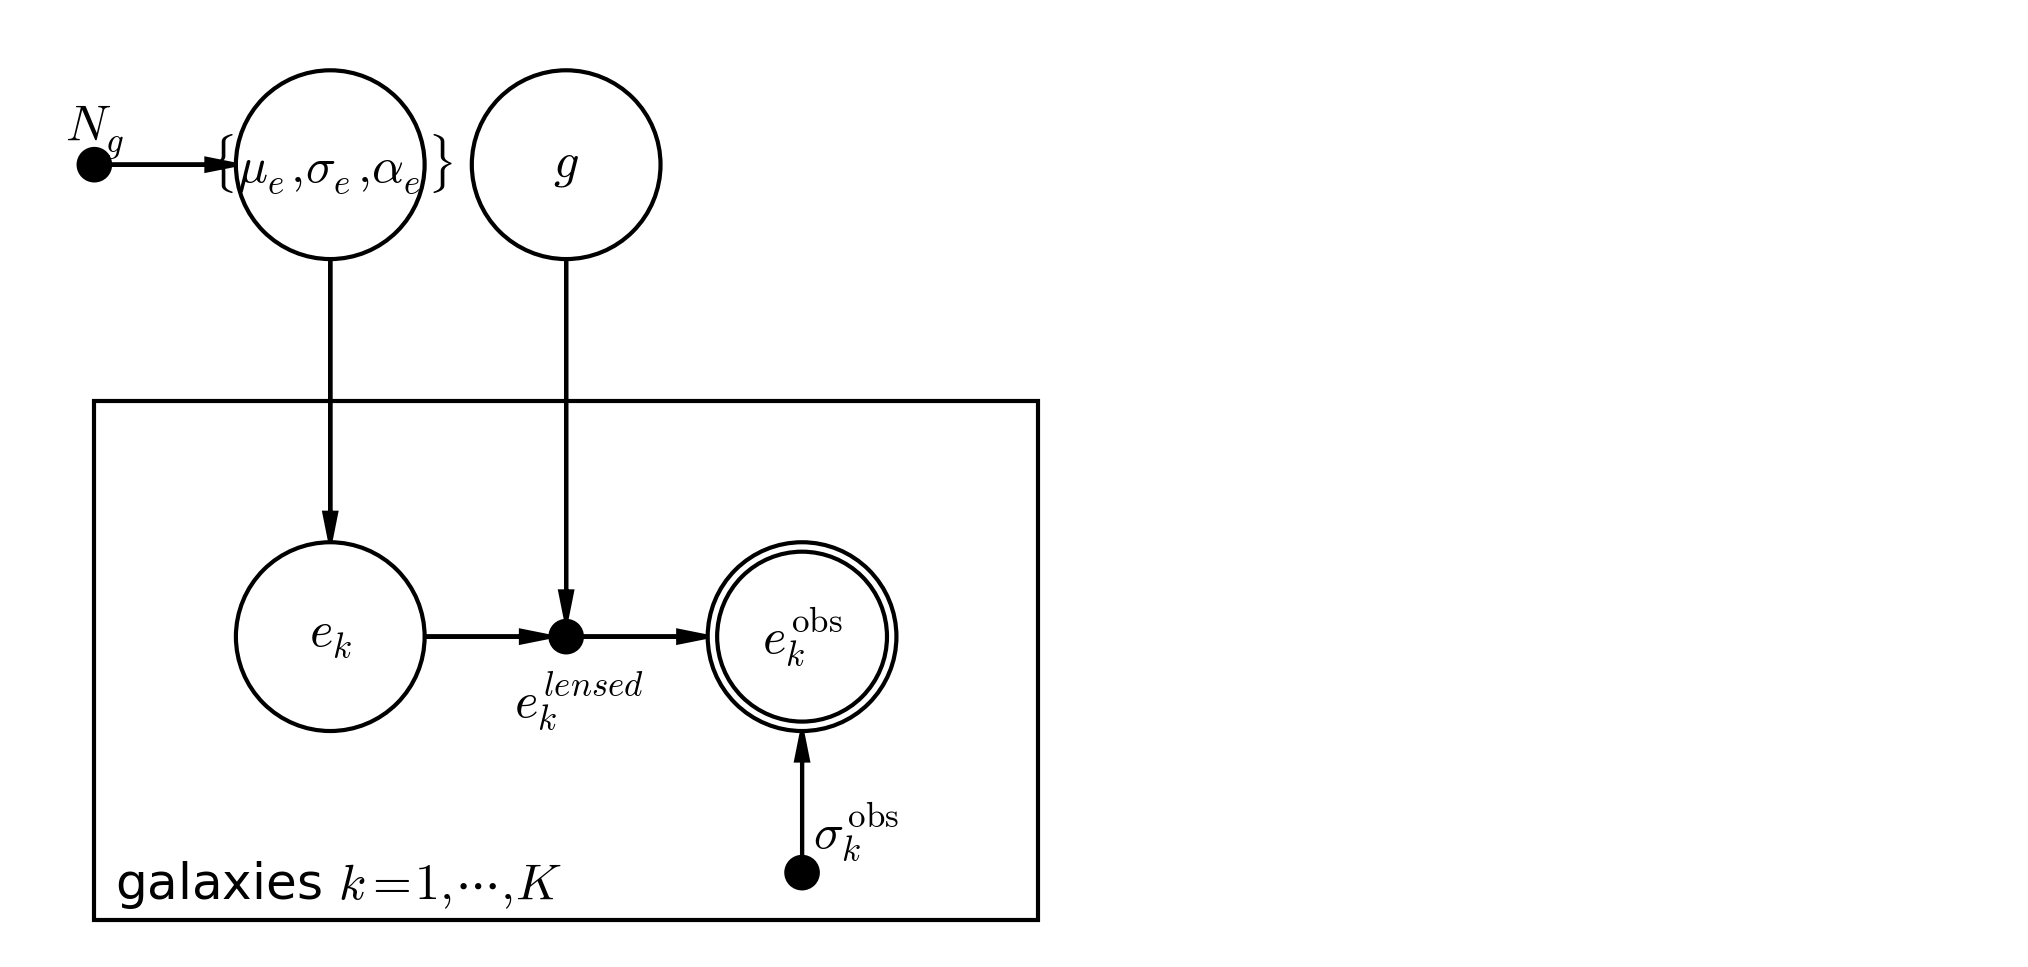

In [6]:
# Display:


Image(filename="flubber_PGM.png",width=800)

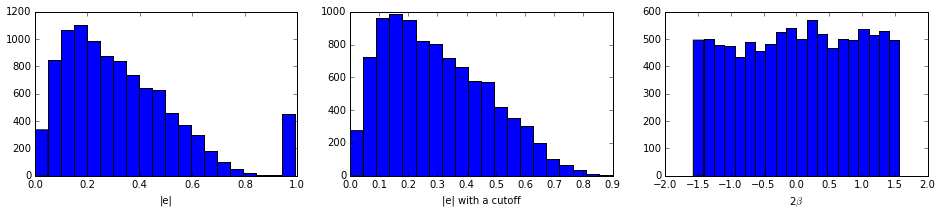

In [3]:
data=np.loadtxt('gr3_e.dat')
e=(data[0]**2+data[1]**2)**0.5
p,=np.where(e<=0.9)
e_cutoff=e[p]
theta=np.arctan(data[1]/data[0])
plt.figure(figsize=[16,10])
plt.subplot(3,3,1)
plt.hist(e,20)
plt.xlabel('|e|')
plt.subplot(3,3,2)
plt.hist(e_cutoff,20)
plt.xlabel('|e| with a cutoff')
plt.subplot(3,3,3)
plt.hist(theta,20)
plt.xlabel(r'2$\beta $')
plt.show()


The spike at 1 is due to improper fit as $|e|>1$ is unphysical. So a cutoff is applied at |e|=0.9

In [5]:


def create_gmm(gmm_param, eobs):
    sum=0
    x=np.linspace(0,max(eobs),len(eobs))
    for i in range(len(gmm_param.means)):
        sum+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum

In [78]:
np.hypot(np.mean(data[0]),np.mean(data[1]))

0.044873033473290837

In [138]:
q,=np.where(np.hypot(data[0],data[1])<0.9)
np.hypot(np.mean(data[0][q]),np.mean(data[1][q]))

0.04422241592070051

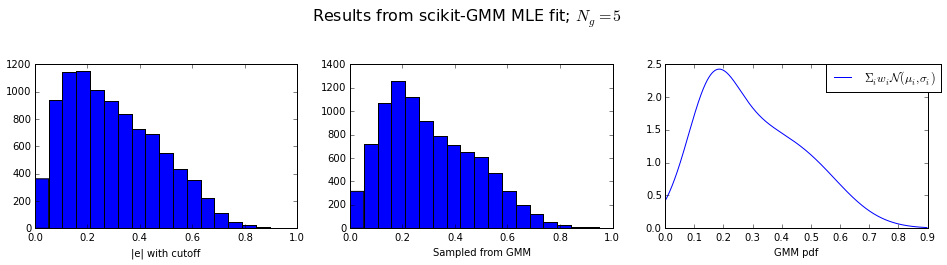

In [162]:
g=mixture.GMM(n_components=5)
m1=g.fit((np.array([e])).T) 
out=m1.sample(len(e))
m2=g.fit((np.array([e_cutoff])).T) 
out2=m2.sample(len(e_cutoff))
class gmm_param:
    def __init__(self,means=m2.means_.T[0], 
                 covars=m2.covars_.T[0],
                weights=m2.weights_):
        self.means=means
        self.weights=weights
        self.covars=covars

samp=gmm_param()
d=create_gmm(samp, e_cutoff)
x=np.linspace(0,max(e_cutoff),len(e_cutoff))
plt.figure(figsize=[16,10])

plt.subplot(3,3,1)
plt.hist(e_cutoff,np.linspace(0,1,20))
plt.xlabel('|e| with cutoff')
plt.subplot(3,3,2)
plt.hist(out2,np.linspace(0,1,20))
plt.xlabel('Sampled from GMM')
plt.subplot(3,3,3)
plt.plot(x,d,label=r'$\Sigma_i w_i \mathcal{N}(\mu_i,\sigma_i)$')
plt.xlabel('GMM pdf')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.suptitle('Results from scikit-GMM MLE fit; $N_g=5$',size=16)
plt.show()


#### Sampling distribution for the kth datapoint, $Pr(e^{obs}_k|e^{lens}_k)$
We choose a Gaussian sampling distribution (with error $\sigma_k$ constant for now):
$Pr(e^{obs}_k|e^{lens}_k,\sigma_k)=\frac{1}{\sqrt{2\pi}\sigma k} e^\frac{−(e^{obs}_k−e^{lens}_k)^2}{2\sigma_k^2}$

#### $Pr(e^{obs}|e^{lens},\sigma)=\Pi_k\frac{1}{\sqrt{2\pi}\sigma_k} e^\frac{−(e^{obs}_k−e^{lens}_k)^2}{2\sigma_k^2}$

#### Conditional PDF $Pr(e^{lens}_k|\{w_i^g,\sigma_i^g,\mu_i^g\},g)$
$Pr(e^{lens}_k|e_k,g)=\delta (e^{lens}_k−\frac{e_k+g}{1+g^*e_k})$ and  $Pr(e_k|\{w_i,\sigma_i,\mu_i\})=\Sigma_i^{N_g} w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)$


For the pdf to be analytical we assume that $g<<e$ and $e^{obs}_k=e_k+g$

$Pr(e^{lens}_k|e_k,g)=\delta (e^{lens}_k−(e_k+g))$ 

###  Joint likelihood, $Pr(e^{obs}|\{w_i^g,\sigma_i^g,\mu_i^g\},g)$ 

Since the intrinsic ellipticities are not interesting, we marginalize them out:
\begin{align}
Pr(e^{obs}|\{w_i,\sigma_i,\mu_i\},g) & = \prod_{k} \int \int Pr(e^{obs}_k|e^{lens}_k) \times Pr(e^{lens}_k|e_k,g) \times  Pr(e_k|\{w_i^g,\sigma_i^g,\mu_i^g\}) \,de_k \,de^{lens}_k\\
                                     & = \prod_{k} \int \int  Pr(e^{obs}_k|e^{lens}_k) \times  \delta (e^{lens}_k−(e_k+g)) \times  Pr(e_k|\{w_i^g,\sigma_i^g,\mu_i^g\}) \,de_k \,de^{lens}_k\\
                                     & = \prod_{k}  \int  \frac{1}{\sqrt{2\pi}\sigma_k} e^\frac{−(e^{obs}_k−(e_k+g))^2}{2\sigma_k^2} \times  \sum_i^{N_g} w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)de_k \\
                                     & = \prod_{k}  \int  \mathcal{N}((e^{obs}_k-g),\sigma_k) \times  \sum_i^{N_g} w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)de_k \\
                                     & = \prod_{k} \sum_i^{N_g} \int  \mathcal{N}((e^{obs}_k-g),\sigma_k) \times   w_i^g \mathcal{N}(\mu_i^g,\sigma_i^g)de_k \\ 
\end{align} 
The multiplication of two gaussian functions is another gaussian function with a gaussian normalization factor. Integrating over $e_k$ gives
\begin{align}
Pr(e^{obs}|\{w_i,\sigma_i,\mu_i\},g) & = \prod_{k} \sum_i^{N_g} w_i^g \mathcal{N}(\mu_i^g+g,\sqrt{\sigma_k^2+{\sigma_i^g}^2}) \\ 
\end{align}         

GMM parametrs and g are taken to have uniform priors


In [117]:
np.random.seed(1)

def log_prior_g(g):
    gmin,gmax=-1.,1.
    if ((g>=gmin) and (g<=gmax)) :
        return np.log(1/(gmax-gmin))
    else:
        return -np.inf
def log_prior_gmm(gmm_param):
    N=len(gmm_param.means)
    means_min,means_max=0.,1.
    covars_min,covars_max=0.,1.
    weights_min,weights_max=0.,1.
    for i in range(N):
        if ((gmm_param.means[i]>means_max) or (gmm_param.means[i]<means_min) or 
            (gmm_param.covars[i]>covars_max) or (gmm_param.covars[i]<covars_min) or 
            (gmm_param.weights[i]<weights_min) or (gmm_param.weights[i]>weights_max) ):
            return -np.inf
    return np.log(1/((means_max-means_min)*(covars_max-covars_min)*(weights_max-weights_min)))

def log_likelihood(eobs,gmm_param,g,sigmak):
    val=0
    for i in range(len(gmm_param.means)):
        C=(sigmak**2+gmm_param.covars[i])
        val+= np.exp(-((-eobs+g+gmm_param.means[i])**2)/(2*C))*gmm_param.weights[i]/(2*np.pi*C)**0.5
        #print val
    #print np.sum(np.log(val))
    return np.sum(np.log(val))
    #return val
    
def log_posterior(eobs,gmm_param,g,sigmak):

    return log_likelihood(eobs,gmm_param,g,sigmak)+log_prior_g(g)+log_prior_gmm(gmm_param)

In [118]:
def metropolis( eobs,gmm_param1,g,sigmak, g_stepsize,
               m_stepsize,w_stepsize,c_stepsize,nsteps=1000):
    
    log_prob = log_posterior(eobs,gmm_param1,g,sigmak)
    #print log_prob
    
    # Store Markov chain as an array of samples:
    chain,m,s,w,log_probs = [],[],[],[],[]
    
    # Count our accepted proposals:
    naccept = 0
    t=0
    for i in range(nsteps):
        g_new        = g + g_stepsize * np.random.uniform(-1,1)       
        mean_new    = np.array(gmm_param1.means   + m_stepsize*np.random.uniform(-1,1))
        var_new     = np.array(gmm_param1.covars  + c_stepsize*np.random.uniform(-1,1))
        weight_new  = np.array(gmm_param1.weights + w_stepsize*np.random.uniform(-1,1))
        weight_new[-1]=1-(np.sum(weight_new[:-1]))
        #print mean_new
        gmm_new=gmm_param(means=mean_new,covars=var_new, weights=weight_new)
        log_prob_new = log_posterior(eobs,gmm_new,g_new,sigmak)
        #print log_prob_new,log_prob    
        if np.log(np.random.rand()) < (log_prob_new - log_prob):
            # accept, and move to the proposed position:
            gmm_param1=gmm_new
            g = g_new
            log_prob = log_prob_new
            naccept += 1
            
            chain.append(g)
            m.append(gmm_param1.means)
            s.append(gmm_param1.covars)
            w.append(gmm_param1.weights)
            log_probs.append(log_prob)
        else:
            # reject, and store the same sample as before:
            pass
        chain.append(g)
        m.append(gmm_param1.means)
        s.append(gmm_param1.covars)
        w.append(gmm_param1.weights)
        log_probs.append(log_prob)

        
    acceptance_rate = naccept/float(nsteps) 
    print 'Acceptance Ratio:',acceptance_rate
    return chain,m,s,w,log_probs

In [152]:
g=mixture.GMM(n_components=5)
m2=g.fit((np.array([e_cutoff])).T) 
class gmm_param:
    def __init__(self,means=m2.means_.T[0], 
                 covars=m2.covars_.T[0],
                weights=m2.weights_):
        self.means=means
        self.weights=weights
        self.covars=covars

In [153]:
eobs=e_cutoff
sigmak=0.05
g=0.04422
input_param=gmm_param()
g_stepsize=0.00001
m_stepsize, c_stepsize, w_stepsize= 0.001,0.0001,0.001
chain,m,s,w,log_probs=metropolis( e_cutoff,input_param,g,sigmak, g_stepsize,m_stepsize,w_stepsize,c_stepsize,nsteps=10000)

Acceptance Ratio: 0.7596


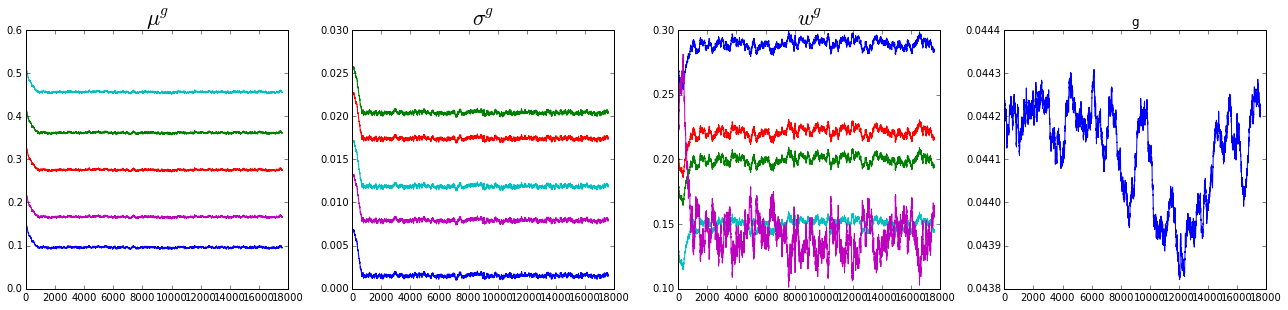

In [154]:
fig = plt.figure(figsize=[18,16])

ax1 = plt.subplot(441)
ax1.plot(m)
ax1.set_title(r'$\mu ^g$',size=22)
ax2 = plt.subplot(442)
ax2.plot(s)
ax2.set_title(r'$\sigma ^g$',size=22)
ax3 = plt.subplot(443)
ax3.plot(w)
ax3.set_title(r'$w ^g$',size=22)
ax4 = plt.subplot(444)
ax4.plot(chain)
ax4.set_title('g',size=12)
plt.tight_layout()





In [148]:
g=mixture.GMM(n_components=3)
m2=g.fit((np.array([e_cutoff])).T) 
class gmm_param:
    def __init__(self,means=m2.means_.T[0], 
                 covars=m2.covars_.T[0],
                weights=m2.weights_):
        self.means=means
        self.weights=weights
        self.covars=covars
eobs=e_cutoff
sigmak=0.05
g=0.04422
input_param=gmm_param()
g_stepsize=0.00001
m_stepsize, c_stepsize, w_stepsize= 0.001,0.0001,0.001
chain,m,s,w,log_probs=metropolis( e_cutoff,input_param,g,sigmak, g_stepsize,m_stepsize,w_stepsize,c_stepsize,nsteps=10000)

Acceptance Ratio: 0.7857


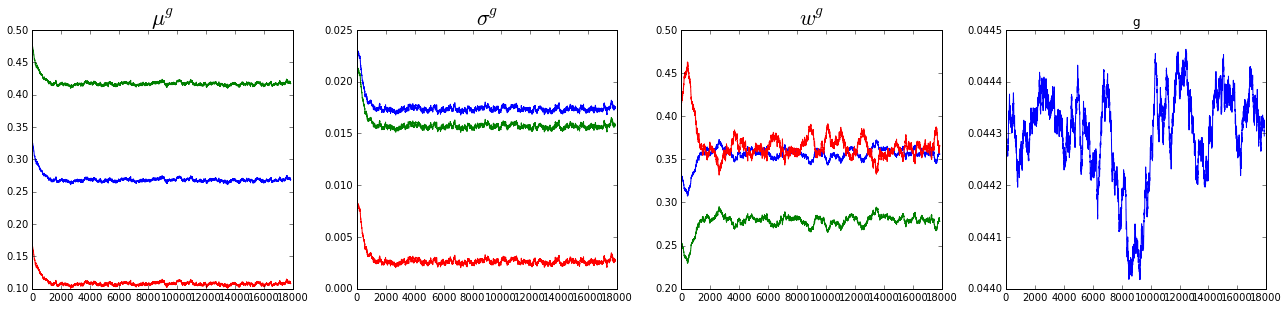

In [149]:
fig = plt.figure(figsize=[18,16])

ax1 = plt.subplot(441)
ax1.plot(m)
ax1.set_title(r'$\mu ^g$',size=22)
ax2 = plt.subplot(442)
ax2.plot(s)
ax2.set_title(r'$\sigma ^g$',size=22)
ax3 = plt.subplot(443)
ax3.plot(w)
ax3.set_title(r'$w ^g$',size=22)
ax4 = plt.subplot(444)
ax4.plot(chain)
ax4.set_title('g',size=12)
plt.tight_layout()






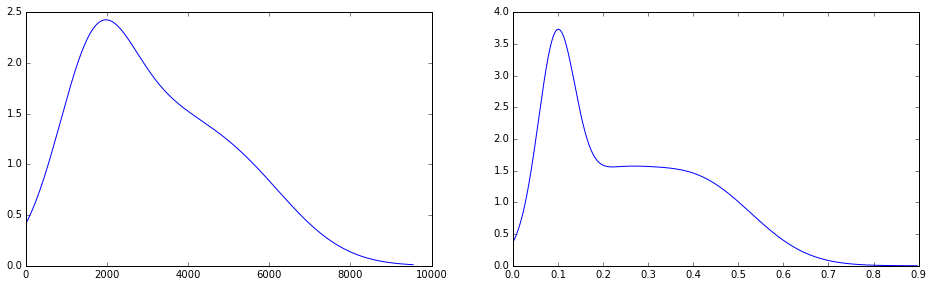

In [167]:

plt.figure(figsize=[16,10])
plt.subplot(2,2,1)
plt.plot(d)
plt.subplot(2,2,2)
plt.plot(x,new_d)

In [197]:
def f(gmm_param, x):
    sum=0
    for i in range(len(gmm_param.means)):
        sum+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum
xmin = 0.0
xmax = 1.0

# find ymin-ymax
numSteps = 1000000 # bigger the better but slower!
ymin = f(new_gmm,xmin)
ymax = ymin
for i in range(numSteps):
    x = xmin + (xmax - xmin) * float(i) / numSteps
    y = f(new_gmm,x)
    if y < ymin: ymin = y
    if y > ymax: ymax = y

In [198]:
n = len(e_cutoff) # how many random numbers to generate
e_int=[]
for i in range(n):
    while True:
        # generate a random number between 0 to 1
        xr = np.random.random()
        yr = np.random.random()
        x = xmin + (xmax - xmin) * xr
        y = ymin + (ymax - ymin) * yr
        if y <= f(new_gmm,x):
            e_int.append(xr)
            break

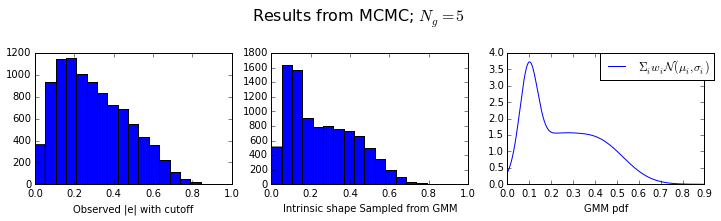

In [202]:
new_gmm=gmm_param(means=np.mean(m[200:],axis=0),covars=np.mean(s[200:],axis=0),weights=np.mean(w[200:],axis=0))
new_d=create_gmm(new_gmm, e_cutoff)
es=np.linspace(0,max(e_cutoff),len(e_cutoff))

plt.subplot(3,3,1)
plt.hist(e_cutoff,np.linspace(0,1,20))
plt.xlabel('Observed |e| with cutoff')
plt.subplot(3,3,2)
plt.hist(e_int,np.linspace(0,1,20))
plt.xlabel('Intrinsic shape Sampled from GMM')
plt.subplot(3,3,3)
plt.plot(es,new_d,label=r'$\Sigma_i w_i \mathcal{N}(\mu_i,\sigma_i)$')
plt.xlabel('GMM pdf')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.suptitle('Results from MCMC; $N_g=5$',size=16)
plt.show()

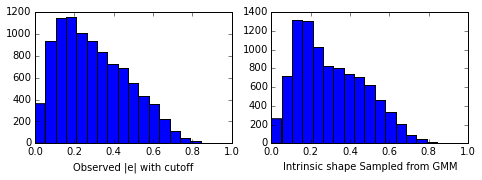

In [209]:
rshr=np.mean(chain)
e_meas=e_int+rshr+np.random.normal(0, sigmak, len(e_int))
plt.subplot(3,3,1)
plt.hist(e_cutoff,np.linspace(0,1,20))
plt.xlabel('Observed |e| with cutoff')
plt.subplot(3,3,2)
plt.hist(e_meas,np.linspace(0,1,20))
plt.xlabel('Intrinsic shape Sampled from GMM')

In [170]:
np.mean(m[200:],axis=0),np.mean(s[200:],axis=0),np.mean(w[200:],axis=0)

(array([ 0.0963444 ,  0.36210018,  0.27603332,  0.45645005,  0.16723647]),
 array([ 0.00159508,  0.02046813,  0.01748   ,  0.01194035,  0.00798986]),
 array([ 0.28839689,  0.19896083,  0.22048918,  0.1491646 ,  0.14298851]))

(array([ 114.,    0.,   98.,    0.,  103.,    0.,  114.,    0.,  108.,
           0.,    0.,   85.,    0.,  107.,    0.,  116.,    0.,  113.,
           0.,   42.]),
 array([  0.00000000e+00,   4.23169837e-05,   8.46339674e-05,
          1.26950951e-04,   1.69267935e-04,   2.11584918e-04,
          2.53901902e-04,   2.96218886e-04,   3.38535870e-04,
          3.80852853e-04,   4.23169837e-04,   4.65486821e-04,
          5.07803804e-04,   5.50120788e-04,   5.92437772e-04,
          6.34754755e-04,   6.77071739e-04,   7.19388723e-04,
          7.61705707e-04,   8.04022690e-04,   8.46339674e-04]),
 <a list of 20 Patch objects>)

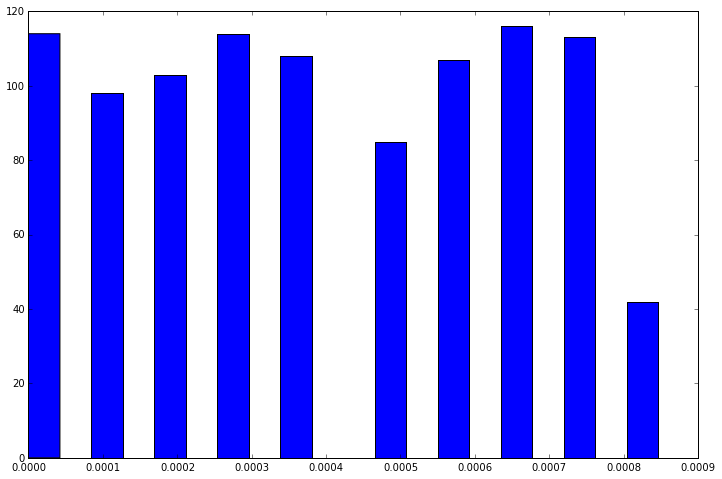

In [191]:
def random_distr(l):
    r = np.random.uniform(0, 3.5)
    s = 0
    for item, prob in l:
        s += prob
        if s >= r:
            return item
    return l[-1] 
arr = [] 
for i in range(0, 1000):
    arr.append(random_distr(prob))
plt.hist(arr,20)

In [184]:
prob=np.vstack([x,new_d]).T
prob[0]

array([ 0.        ,  0.36574649])

### Problems:
- too many parameters: doesn't converge
- step size and initial point

In [206]:
np.random.normal?